# 1 - Data Preperation


### Mount Google Drive and Unzip Dataset


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/Skin-Cancer-Detection/data/malignant_classification/malignant_classification.zip" -d "/content/malignant_classification"

### Import Required Libraries


In [ ]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.utils import register_keras_serializable
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121, Xception
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

### Set Seed for Reproducibility


In [4]:
SEED = 55
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

### Load and Explore the Balanced Dataset


In [ ]:
df = pd.read_csv(
    '/content/malignant_classification/malignant_classification.csv')
df

,image_name,diagnosis,benign_malignant,target,path
0,ISIC_0028763,scc,malignant,1,data/ISIC_2019/train/ISIC_0028763.jpg
1,ISIC_0031470,bcc,malignant,1,data/ISIC_2019/train/ISIC_0031470.jpg
2,ISIC_0061836,akiec,malignant,1,data/ISIC_2019/train/ISIC_0061836.jpg
3,ISIC_0057526,akiec,malignant,1,data/ISIC_2019/train/ISIC_0057526.jpg
4,ISIC_0027675,bcc,malignant,1,data/ISIC_2019/train/ISIC_0027675.jpg
...,...,...,...,...,...
2357,ISIC_0055870,scc,malignant,1,data/ISIC_2019/train/ISIC_0055870.jpg
2358,ISIC_0058119,akiec,malignant,1,data/ISIC_2019/train/ISIC_0058119.jpg
2359,ISIC_0056177,bcc,malignant,1,data/ISIC_2019/train/ISIC_0056177.jpg
2360,ISIC_0073116,bcc,malignant,1,data/ISIC_2019/train/ISIC_0073116.jpg


#### Distribution


In [6]:
df['diagnosis'].value_counts()

,count
diagnosis,
bcc,867
akiec,867
scc,628


### Split Data into Train, Validation and Test Sets


In [7]:
X = df[['image_name', 'path']]
y = df['diagnosis']

In [8]:
X

,image_name,path
0,ISIC_0028763,data/ISIC_2019/train/ISIC_0028763.jpg
1,ISIC_0031470,data/ISIC_2019/train/ISIC_0031470.jpg
2,ISIC_0061836,data/ISIC_2019/train/ISIC_0061836.jpg
3,ISIC_0057526,data/ISIC_2019/train/ISIC_0057526.jpg
4,ISIC_0027675,data/ISIC_2019/train/ISIC_0027675.jpg
...,...,...
2357,ISIC_0055870,data/ISIC_2019/train/ISIC_0055870.jpg
2358,ISIC_0058119,data/ISIC_2019/train/ISIC_0058119.jpg
2359,ISIC_0056177,data/ISIC_2019/train/ISIC_0056177.jpg
2360,ISIC_0073116,data/ISIC_2019/train/ISIC_0073116.jpg


In [9]:
y

,diagnosis
0,scc
1,bcc
2,akiec
3,akiec
4,bcc
...,...
2357,scc
2358,akiec
2359,bcc
2360,bcc


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

#### Display Class Distribution in Train, Validation, and Test Sets


In [11]:
df_train = pd.concat([X_train, y_train], axis=1)
print("Train:", df_train['diagnosis'].value_counts().to_dict())

Train: {'akiec': 624, 'bcc': 624, 'scc': 452}


In [12]:
df_val = pd.concat([X_val, y_val], axis=1)
print("Validation:", df_val['diagnosis'].value_counts().to_dict())

Validation: {'akiec': 156, 'bcc': 156, 'scc': 113}


In [13]:
df_test = pd.concat([X_test, y_test], axis=1)
print("Test:", df_test['diagnosis'].value_counts().to_dict())

Test: {'akiec': 87, 'bcc': 87, 'scc': 63}


In [14]:
le = LabelEncoder()

df_train['label'] = le.fit_transform(df_train['diagnosis'])
df_val['label'] = le.transform(df_val['diagnosis'])
df_test['label'] = le.transform(df_test['diagnosis'])

class_names = le.classes_
num_classes = len(class_names)

print("Class labels:", list(zip(class_names, le.transform(class_names))))

Class labels: [('akiec', np.int64(0)), ('bcc', np.int64(1)), ('scc', np.int64(2))]


### Update Image Paths for Google Colab Environment


In [15]:
NEW_ROOT = "/content/malignant_classification/malignant_images"

df_train['path'] = df_train['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_val['path'] = df_val['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_test['path'] = df_test['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))

In [16]:
df_train

,image_name,path,diagnosis,label
277,ISIC_0066861,/content/malignant_classification/malignant_im...,akiec,0
707,ISIC_0069484,/content/malignant_classification/malignant_im...,bcc,1
878,ISIC_0069283,/content/malignant_classification/malignant_im...,akiec,0
368,ISIC_0071669,/content/malignant_classification/malignant_im...,akiec,0
1464,ISIC_0056206,/content/malignant_classification/malignant_im...,bcc,1
...,...,...,...,...
650,ISIC_0056493,/content/malignant_classification/malignant_im...,scc,2
2105,ISIC_0054272,/content/malignant_classification/malignant_im...,akiec,0
1365,ISIC_0053736,/content/malignant_classification/malignant_im...,akiec,0
1172,ISIC_0061056,/content/malignant_classification/malignant_im...,bcc,1


In [17]:
df_val

,image_name,path,diagnosis,label
1486,ISIC_0024329,/content/malignant_classification/malignant_im...,scc,2
490,ISIC_0066892,/content/malignant_classification/malignant_im...,akiec,0
1750,ISIC_0069715,/content/malignant_classification/malignant_im...,bcc,1
214,ISIC_0064371,/content/malignant_classification/malignant_im...,scc,2
721,ISIC_0057273,/content/malignant_classification/malignant_im...,bcc,1
...,...,...,...,...
1054,ISIC_0057132,/content/malignant_classification/malignant_im...,bcc,1
1822,ISIC_0024948,/content/malignant_classification/malignant_im...,akiec,0
2005,ISIC_0055331,/content/malignant_classification/malignant_im...,akiec,0
689,ISIC_0070421,/content/malignant_classification/malignant_im...,scc,2


In [18]:
df_test

,image_name,path,diagnosis,label
1278,ISIC_0066913,/content/malignant_classification/malignant_im...,akiec,0
984,ISIC_0065150,/content/malignant_classification/malignant_im...,akiec,0
1124,ISIC_0069066,/content/malignant_classification/malignant_im...,bcc,1
2182,ISIC_0025953,/content/malignant_classification/malignant_im...,akiec,0
2220,ISIC_0032206,/content/malignant_classification/malignant_im...,akiec,0
...,...,...,...,...
1106,ISIC_0025509,/content/malignant_classification/malignant_im...,bcc,1
880,ISIC_0026549,/content/malignant_classification/malignant_im...,scc,2
1887,ISIC_0059032,/content/malignant_classification/malignant_im...,akiec,0
2006,ISIC_0063346,/content/malignant_classification/malignant_im...,bcc,1


## Define Helper Function


### Visualize Training Metrics


In [19]:
def visualize_modeling_results(results):
    history = results.history
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### Visualize Confusion Matrix


In [ ]:
def plot_confusion_matrices_only(model, data_generator, class_labels, title_suffix=''):
    y_pred_probs = model.predict(data_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = data_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix {title_suffix}")
    plt.show()

    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    disp_norm = ConfusionMatrixDisplay(
        confusion_matrix=cm_norm, display_labels=class_labels)
    disp_norm.plot(cmap='Greens')
    plt.title(f"Normalized Confusion Matrix {title_suffix}")
    plt.show()

### Evaluate Model to Dataframe


In [21]:
def evaluate_model_to_dataframe(model, train_gen, val_gen, metric_names=None):
    train_results = model.evaluate(train_gen, verbose=0)
    val_results = model.evaluate(val_gen, verbose=0)

    if metric_names is None:
        metric_names = model.metrics_names
    metric_names = [name.capitalize() if name !=
                    'loss' else 'Loss' for name in metric_names]

    results_df = pd.DataFrame(columns=metric_names, index=[
                              'Train', 'Validation'])
    results_df.loc['Train'] = train_results[:len(metric_names)]
    results_df.loc['Validation'] = val_results[:len(metric_names)]

    return results_df

### Save Model and Results


In [22]:
def save_model_and_results(model, model_name, model_dir, local_path, results_df=None):
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(local_path, exist_ok=True)

    model.save(os.path.join(model_dir, f"{model_name}.keras"))
    model.save(os.path.join(local_path, f"{model_name}.keras"))

    if results_df is not None:
        results_path = os.path.join(model_dir, f"{model_name}_results.csv")
        results_df.to_csv(results_path, index=False)

    print(f"Saved model to: {model_dir} and {local_path}")
    if results_df is not None:
        print(f"Saved results CSV to: {results_path}")

### Evaluate on Test Dataset


In [23]:
def evaluate_on_test_set(model, data_generator, class_labels, title='Confusion Matrix - Test Set'):
    y_pred_probs = model.predict(data_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = data_generator.classes

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# 2 - Model Training


## CNN


### Generate Data


In [ ]:
import gc

import tensorflow as tf
import torch

In [ ]:
class_labels = ['akiec', 'bcc']

In [ ]:
IMG_SIZE = 224
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    shear_range=0.20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='path',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='path',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='categorical'
)

Found 1248 validated image filenames belonging to 2 classes.
Found 312 validated image filenames belonging to 2 classes.
Found 174 validated image filenames belonging to 2 classes.


### Custom-CNN


In [ ]:
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dense(2, activation='softmax')
])

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0)

model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint('cnn_model.keras', monitor='val_loss',
                    save_best_only=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
model_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - AUC: 0.5400 - Precision: 0.5370 - Recall: 0.5370 - accuracy: 0.5370 - loss: 1.4493
Epoch 1: val_loss improved from inf to 1.09137, saving model to cnn_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 533ms/step - AUC: 0.5403 - Precision: 0.5371 - Recall: 0.5371 - accuracy: 0.5371 - loss: 1.4464 - val_AUC: 0.5324 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 1.0914 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - AUC: 0.6217 - Precision: 0.5906 - Recall: 0.5906 - accuracy: 0.5906 - loss: 1.1467
Epoch 2: val_loss improved from 1.09137 to 1.08795, saving model to cnn_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 530ms/step - AUC: 0.6214 - Precision: 0.5902 - Recall: 0.5902 - accuracy: 0.5902 - loss: 1.1469 - val_AUC: 0.5482 - val_Precision: 0.5064 - val_Recall: 0.5064 - val_accuracy: 0.5064 - val_loss: 1.0879 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/

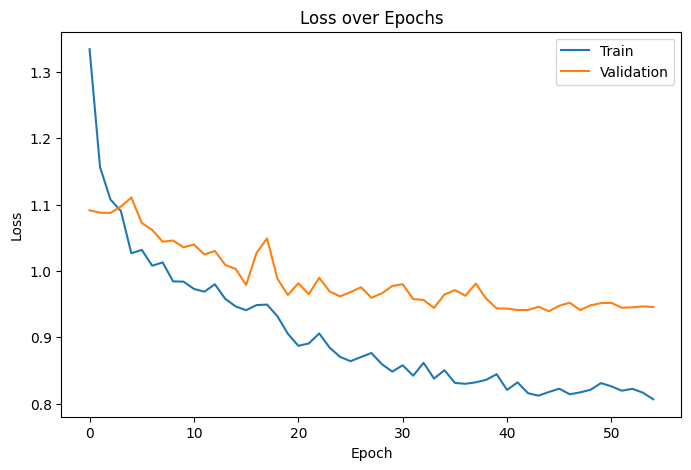

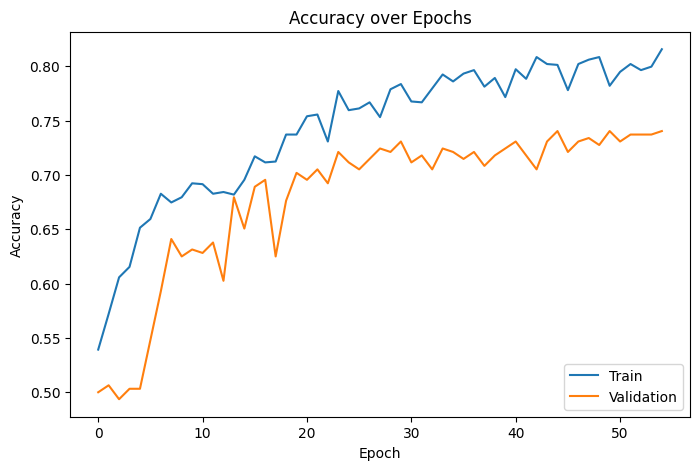

In [ ]:
visualize_modeling_results(model_history)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step


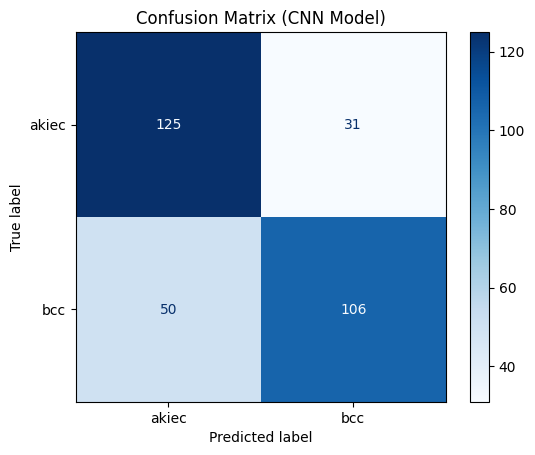

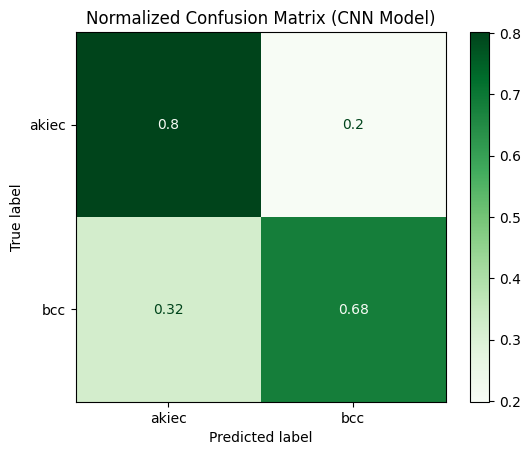

In [ ]:
plot_confusion_matrices_only(
    model, val_generator, class_labels=class_labels, title_suffix='(CNN Model)')

In [ ]:
model_results = evaluate_model_to_dataframe(
    model, train_generator, val_generator)

In [ ]:
display(model_results)

,Loss,Compile_metrics
Train,0.753811,0.830128
Validation,0.939176,0.740385


In [ ]:
save_model_and_results(
    model=model,
    model_name="cnn_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/cnn_model_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step
Classification Report:
              precision    recall  f1-score   support

       akiec       0.74      0.74      0.74        87
         bcc       0.74      0.74      0.74        87

    accuracy                           0.74       174
   macro avg       0.74      0.74      0.74       174
weighted avg       0.74      0.74      0.74       174



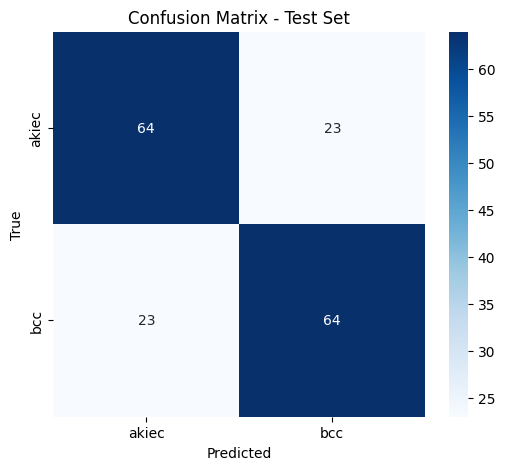

In [ ]:
model = load_model('cnn_model.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

#### Fine-Tuning


In [ ]:
model.load_weights('/content/cnn_model.keras')

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=SGD(learning_rate=5e-5, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint('cnn_finetuned.keras',
                    save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=13,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - AUC: 0.8822 - Precision: 0.8010 - Recall: 0.8010 - accuracy: 0.8010 - loss: 0.8881
Epoch 1: val_loss improved from inf to 1.00725, saving model to cnn_finetuned.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 673ms/step - AUC: 0.8821 - Precision: 0.8010 - Recall: 0.8010 - accuracy: 0.8010 - loss: 0.8883 - val_AUC: 0.8044 - val_Precision: 0.7244 - val_Recall: 0.7244 - val_accuracy: 0.7244 - val_loss: 1.0073 - learning_rate: 5.0000e-05
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - AUC: 0.8788 - Precision: 0.7930 - Recall: 0.7930 - accuracy: 0.7930 - loss: 0.8916
Epoch 2: val_loss improved from 1.00725 to 1.00512, saving model to cnn_finetuned.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 505ms/step - AUC: 0.8789 - Precision: 0.7930 - Recall: 0.7930 - accuracy: 0.7930 - loss: 0.8915 - val_AUC: 0.8048 - val_Precision: 0.7308 - val_Recall: 0.7308 - val_accuracy: 0.7308 - val_loss: 1.0051 - learning_rate: 5.0000e-05
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━

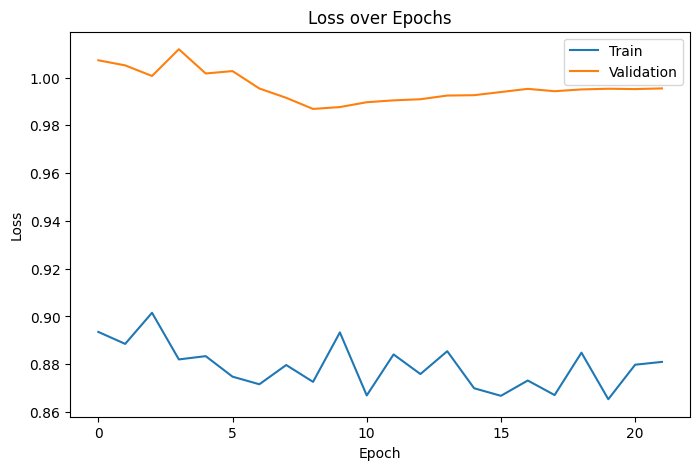

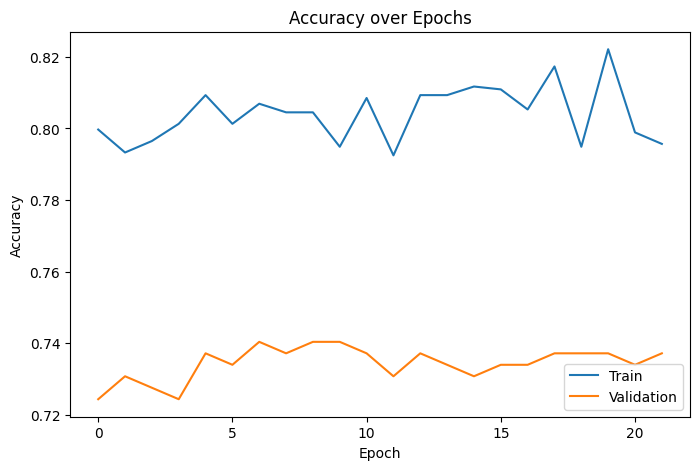

In [ ]:
visualize_modeling_results(history_finetune)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step


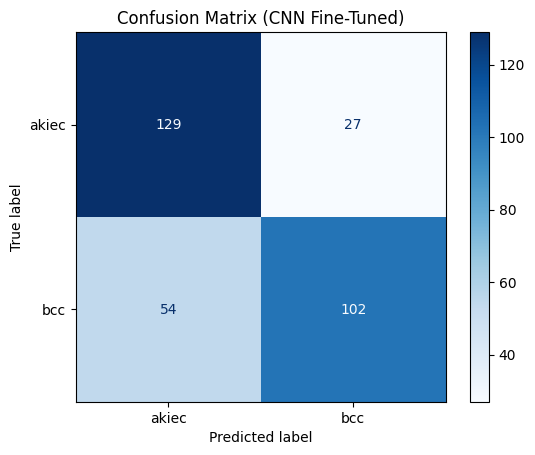

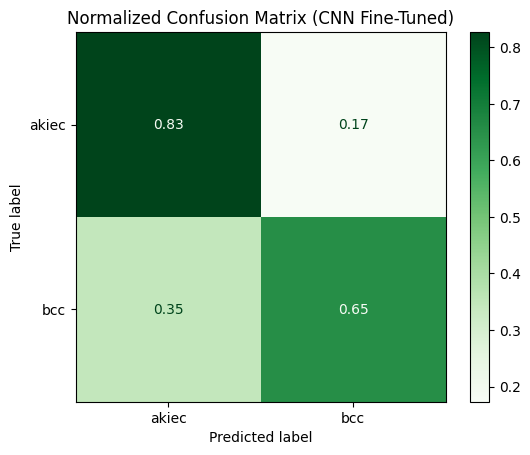

In [ ]:
plot_confusion_matrices_only(
    model, val_generator, class_labels=class_labels, title_suffix='(CNN Fine-Tuned)')

In [ ]:
model_finetuned_results = evaluate_model_to_dataframe(
    model, train_generator, val_generator)

In [ ]:
display(model_finetuned_results)

,Loss,Compile_metrics
Train,0.817578,0.849359
Validation,0.98688,0.740385


In [ ]:
save_model_and_results(
    model=model,
    model_name="cnn_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/cnn_finetuned_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step
Classification Report:
              precision    recall  f1-score   support

       akiec       0.73      0.78      0.76        87
         bcc       0.77      0.71      0.74        87

    accuracy                           0.75       174
   macro avg       0.75      0.75      0.75       174
weighted avg       0.75      0.75      0.75       174



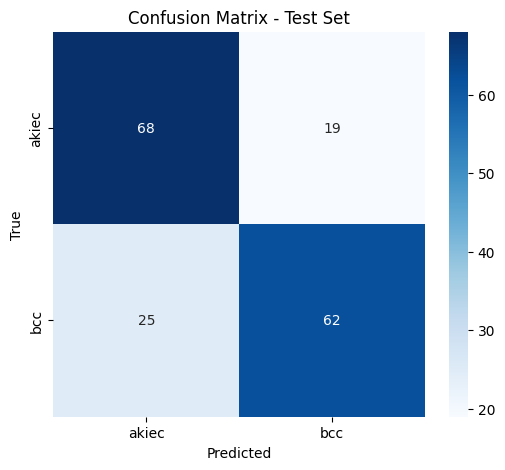

In [ ]:
model = load_model('cnn_finetuned.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

### Xception


In [ ]:
base_model = Xception(weights='imagenet', include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)

output = layers.Dense(2, activation='softmax')(x)

xception_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0)

xception_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_xception = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - AUC: 0.5888 - Precision: 0.5622 - Recall: 0.5622 - accuracy: 0.5622 - loss: 0.9486
Epoch 1: val_loss improved from inf to 0.89976, saving model to xception_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 49s 854ms/step - AUC: 0.5893 - Precision: 0.5624 - Recall: 0.5624 - accuracy: 0.5624 - loss: 0.9481 - val_AUC: 0.5756 - val_Precision: 0.5256 - val_Recall: 0.5256 - val_accuracy: 0.5256 - val_loss: 0.8998 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - AUC: 0.7265 - Precision: 0.6738 - Recall: 0.6738 - accuracy: 0.6738 - loss: 0.8068
Epoch 2: val_loss improved from 0.89976 to 0.81389, saving model to xception_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 517ms/step - AUC: 0.7263 - Precision: 0.6735 - Recall: 0.6735 - accuracy: 0.6735 - loss: 0.8070 - val_AUC: 0.7039 - val_Precision: 0.6506 - val_Recall: 0.6506 - val_accuracy: 0.6506 - val_loss: 0.8139 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━

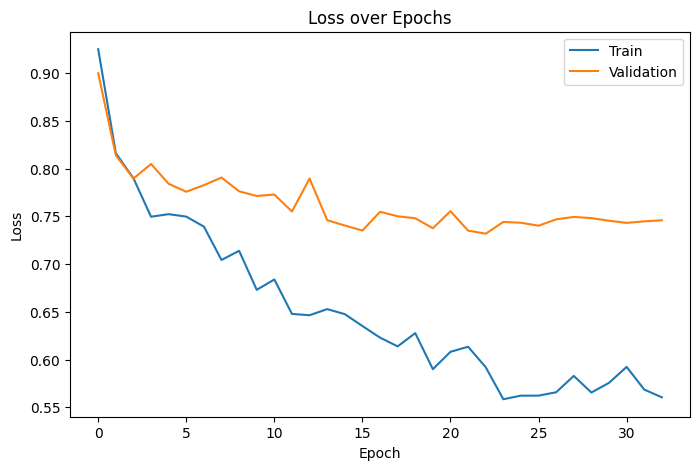

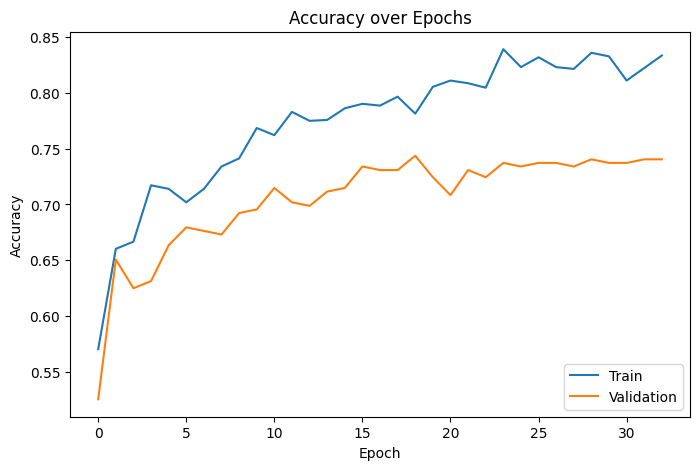

In [ ]:
visualize_modeling_results(history_xception)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step


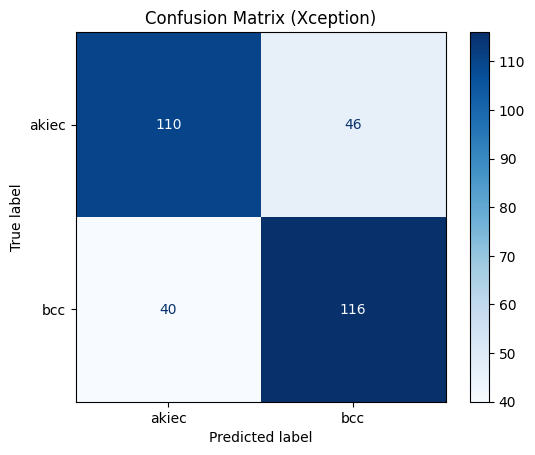

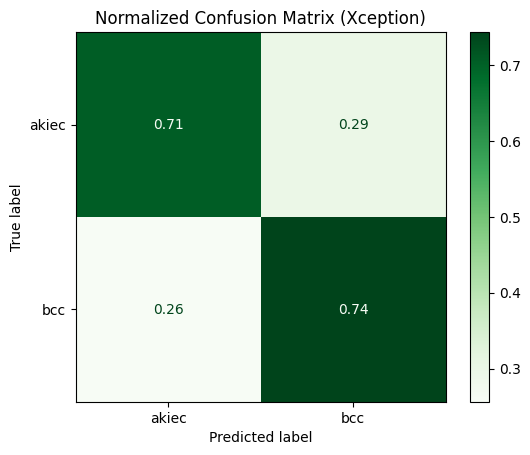

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, class_labels=class_labels, title_suffix='(Xception)')

In [ ]:
xception_model_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

In [ ]:
display(xception_model_results)

,Loss,Compile_metrics
Train,0.512324,0.866987
Validation,0.731774,0.724359


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_model_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_model_results.csv


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Classification Report:
              precision    recall  f1-score   support

       akiec       0.73      0.79      0.76        87
         bcc       0.77      0.70      0.73        87

    accuracy                           0.75       174
   macro avg       0.75      0.75      0.75       174
weighted avg       0.75      0.75      0.75       174



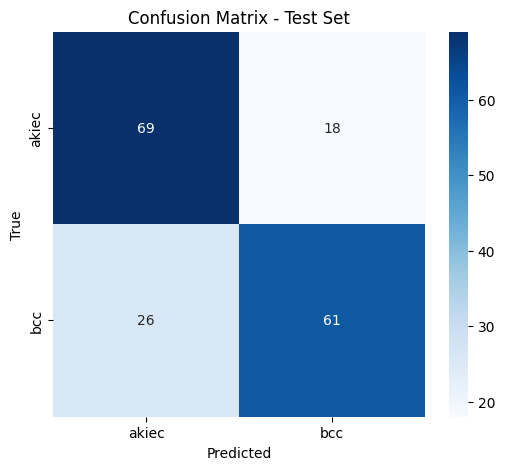

In [ ]:
model = load_model('xception_model.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

#### Fine-Tuning


In [ ]:
xception_model = load_model("/content/xception_model.keras")

In [ ]:
for layer in xception_model.layers[:-90]:
    layer.trainable = False
for layer in xception_model.layers[-90:]:
    layer.trainable = True

In [ ]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

xception_model.compile(
    optimizer=SGD(learning_rate=5e-5, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=11,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_xception_finetuned = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - AUC: 0.7728 - Precision: 0.6989 - Recall: 0.6989 - accuracy: 0.6989 - loss: 0.8376
Epoch 1: val_loss improved from inf to 0.80890, saving model to xception_finetuned.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 757ms/step - AUC: 0.7727 - Precision: 0.6987 - Recall: 0.6987 - accuracy: 0.6987 - loss: 0.8377 - val_AUC: 0.8047 - val_Precision: 0.7372 - val_Recall: 0.7372 - val_accuracy: 0.7372 - val_loss: 0.8089 - learning_rate: 5.0000e-05
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - AUC: 0.7634 - Precision: 0.6990 - Recall: 0.6990 - accuracy: 0.6990 - loss: 0.8424
Epoch 2: val_loss did not improve from 0.80890
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - AUC: 0.7636 - Precision: 0.6991 - Recall: 0.6991 - accuracy: 0.6991 - loss: 0.8422 - val_AUC: 0.7900 - val_Precision: 0.6955 - val_Recall: 0.6955 - val_accuracy: 0.6955 - val_loss: 0.8336 - learning_rate: 5.0000e-05
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - AUC: 0.7785 - Pr

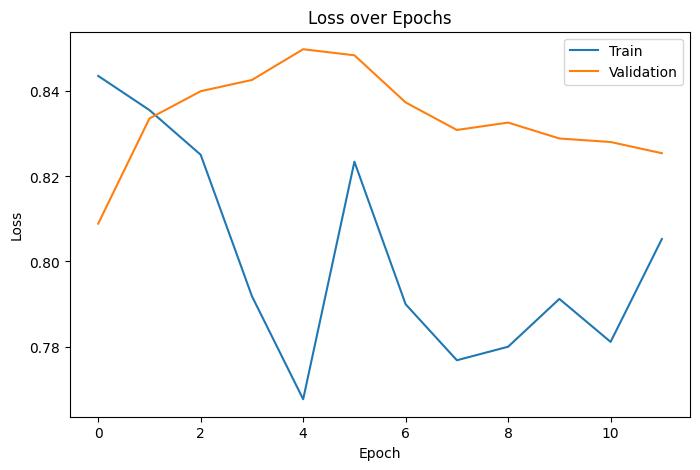

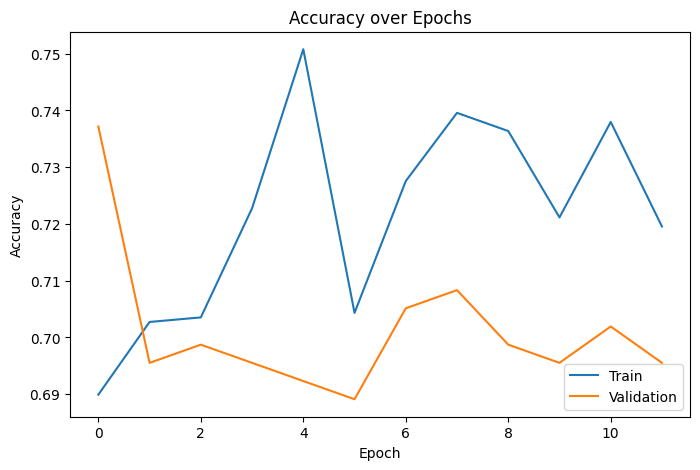

In [ ]:
visualize_modeling_results(history_xception_finetuned)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 403ms/step


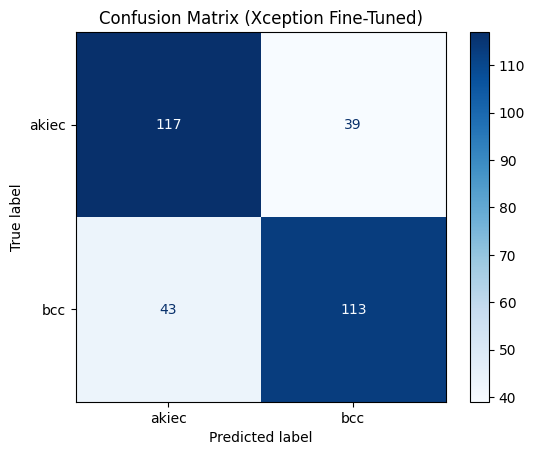

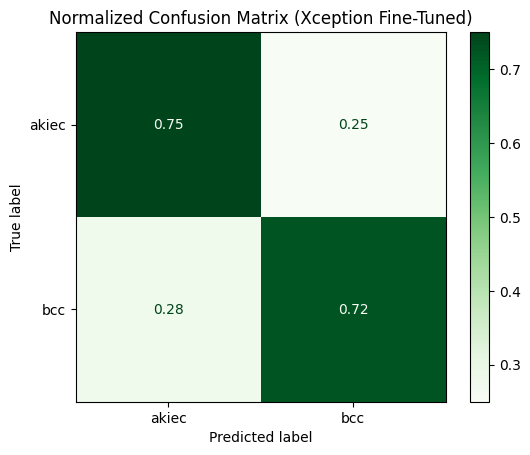

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, class_labels=class_labels, title_suffix='(Xception Fine-Tuned)')

In [ ]:
xception_finetuned_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

In [ ]:
display(xception_finetuned_results)

,Loss,Compile_metrics
Train,0.628191,0.842949
Validation,0.808899,0.737179


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_finetuned_results.csv


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 841ms/step
Classification Report:
              precision    recall  f1-score   support

       akiec       0.70      0.78      0.74        87
         bcc       0.75      0.67      0.71        87

    accuracy                           0.72       174
   macro avg       0.73      0.72      0.72       174
weighted avg       0.73      0.72      0.72       174



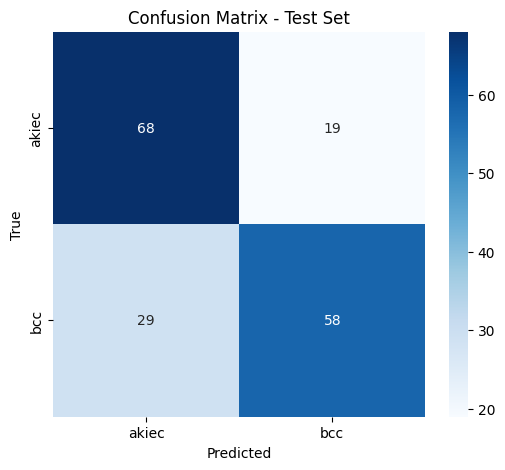

In [ ]:
model = load_model('xception_finetuned.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

### DenseNet121


In [ ]:
base_model = DenseNet121(
    weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
output = layers.Dense(2, activation='softmax')(x)

densenet_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0)

densenet_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - AUC: 0.5529 - Precision: 0.5410 - Recall: 0.5410 - accuracy: 0.5410 - loss: 1.0290
Epoch 1: val_loss improved from inf to 1.56534, saving model to densenet_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - AUC: 0.5540 - Precision: 0.5417 - Recall: 0.5417 - accuracy: 0.5417 - loss: 1.0273 - val_AUC: 0.6140 - val_Precision: 0.5192 - val_Recall: 0.5192 - val_accuracy: 0.5192 - val_loss: 1.5653 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - AUC: 0.7130 - Precision: 0.6740 - Recall: 0.6740 - accuracy: 0.6740 - loss: 0.8261
Epoch 2: val_loss improved from 1.56534 to 0.90584, saving model to densenet_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 717ms/step - AUC: 0.7130 - Precision: 0.6738 - Recall: 0.6738 - accuracy: 0.6738 - loss: 0.8261 - val_AUC: 0.6992 - val_Precision: 0.6314 - val_Recall: 0.6314 - val_accuracy: 0.6314 - val_loss: 0.9058 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s

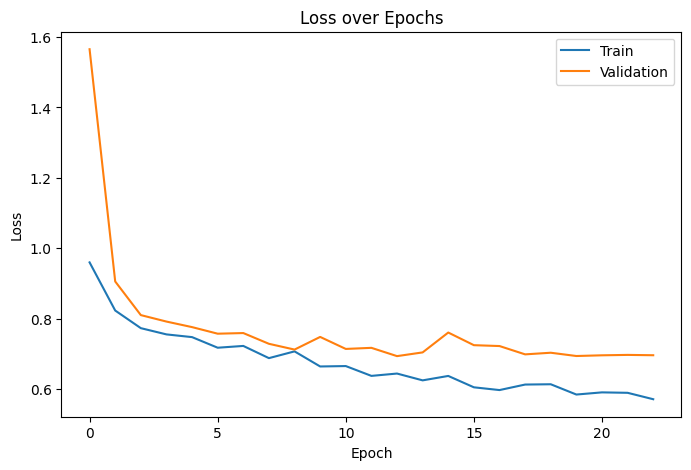

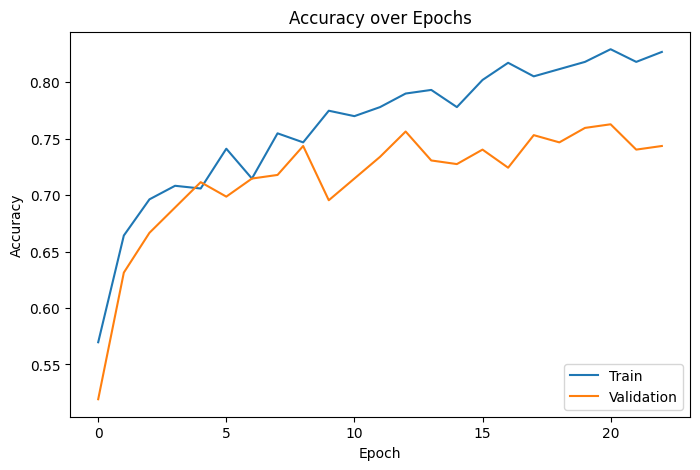

In [ ]:
visualize_modeling_results(history_densenet)

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


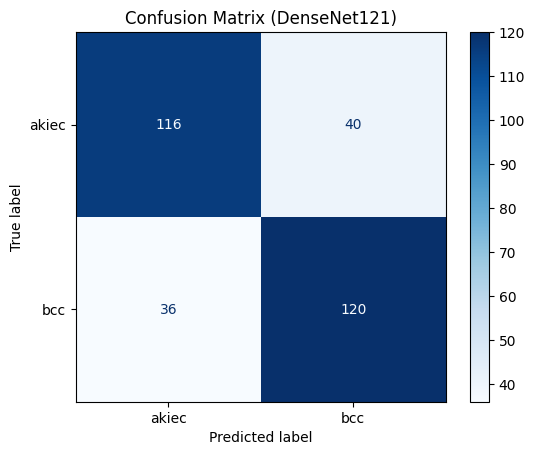

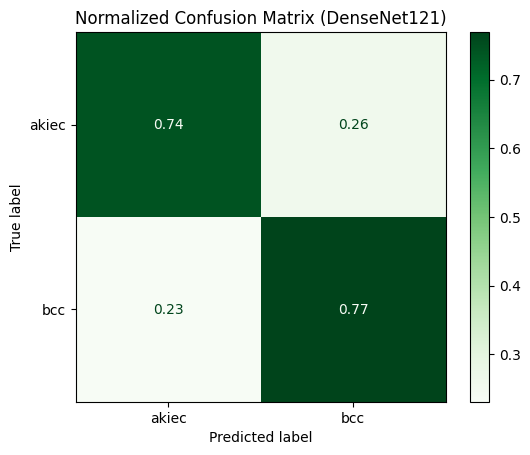

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, class_labels=class_labels, title_suffix='(DenseNet121)')

In [ ]:
densenet_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_results)

,Loss,Compile_metrics
Train,0.570334,0.851763
Validation,0.693812,0.75641


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_model_results.csv


6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step
Classification Report:
              precision    recall  f1-score   support

       akiec       0.82      0.78      0.80        87
         bcc       0.79      0.83      0.81        87

    accuracy                           0.80       174
   macro avg       0.81      0.80      0.80       174
weighted avg       0.81      0.80      0.80       174



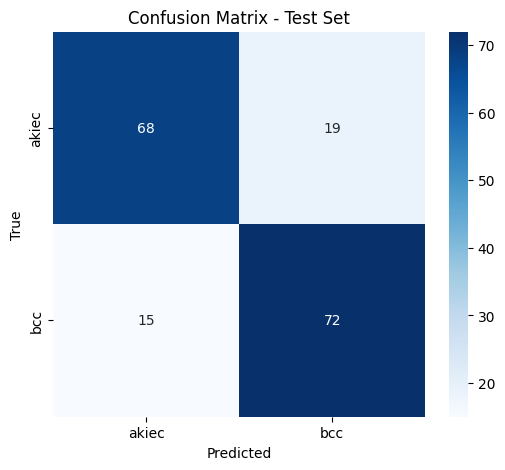

In [ ]:
model = load_model('densenet_model.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

#### Fine-Tuning


In [ ]:
densenet_model = load_model("/content/densenet_model.keras")

In [ ]:
for layer in densenet_model.layers[:-60]:
    layer.trainable = False
for layer in densenet_model.layers[-60:]:
    layer.trainable = True

In [ ]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

densenet_model.compile(
    optimizer=SGD(learning_rate=5e-5, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=11,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_densenet_finetuned = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - AUC: 0.8598 - Precision: 0.7739 - Recall: 0.7739 - accuracy: 0.7739 - loss: 0.7130
Epoch 1: val_loss improved from inf to 0.73734, saving model to densenet_finetuned.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - AUC: 0.8600 - Precision: 0.7741 - Recall: 0.7741 - accuracy: 0.7741 - loss: 0.7129 - val_AUC: 0.8382 - val_Precision: 0.7596 - val_Recall: 0.7596 - val_accuracy: 0.7596 - val_loss: 0.7373 - learning_rate: 5.0000e-05
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - AUC: 0.8600 - Precision: 0.7825 - Recall: 0.7825 - accuracy: 0.7825 - loss: 0.7149
Epoch 2: val_loss did not improve from 0.73734
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 537ms/step - AUC: 0.8601 - Precision: 0.7825 - Recall: 0.7825 - accuracy: 0.7825 - loss: 0.7148 - val_AUC: 0.8268 - val_Precision: 0.7564 - val_Recall: 0.7564 - val_accuracy: 0.7564 - val_loss: 0.7550 - learning_rate: 5.0000e-05
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - AUC: 0.8711 - Prec

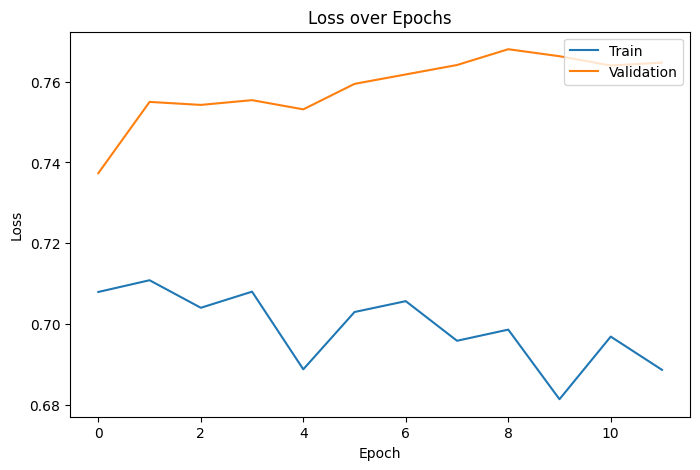

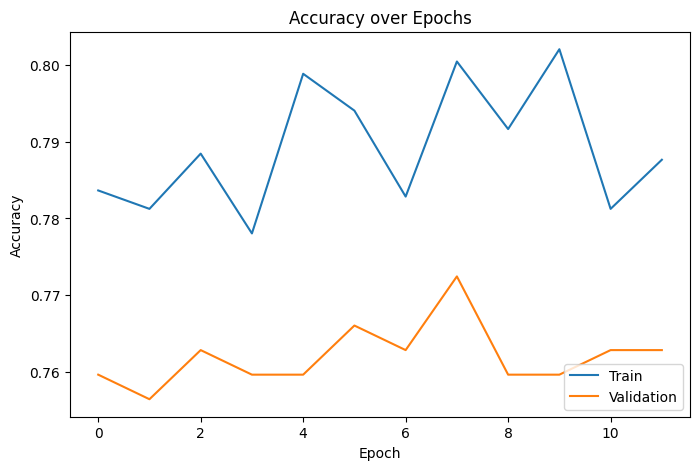

In [ ]:
visualize_modeling_results(history_densenet_finetuned)

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


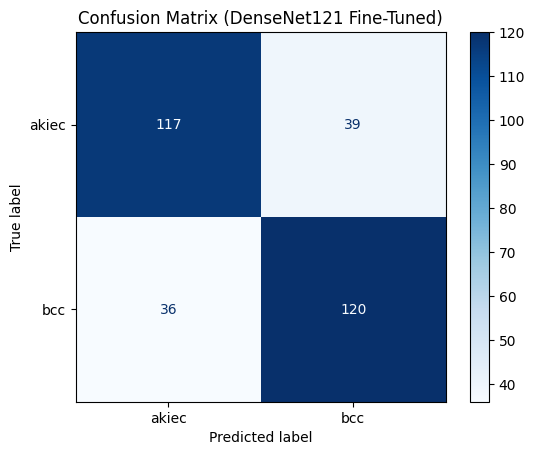

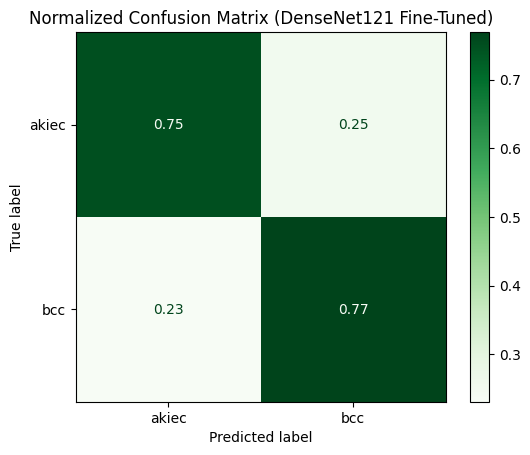

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, class_labels=class_labels, title_suffix='(DenseNet121 Fine-Tuned)')

In [ ]:
densenet_finetuned_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_finetuned_results)

,Loss,Compile_metrics
Train,0.638565,0.842147
Validation,0.737344,0.759615


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_finetuned_results.csv


6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step
Classification Report:
              precision    recall  f1-score   support

       akiec       0.81      0.83      0.82        87
         bcc       0.82      0.80      0.81        87

    accuracy                           0.82       174
   macro avg       0.82      0.82      0.82       174
weighted avg       0.82      0.82      0.82       174



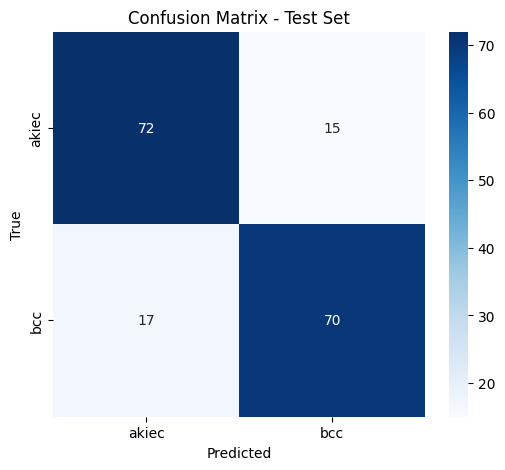

In [ ]:
model = load_model('densenet_finetuned.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

# 3 - Ensemble


In [ ]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import ViTForImageClassification

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 55
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
model_dir = "/content/drive/MyDrive/Skin-Cancer-Detection/models/malignant_models"
csv_path = "/content/malignant_classification/malignant_classification.csv"
image_root = "/content/malignant_classification/malignant_images"

In [ ]:
df = pd.read_csv(csv_path)
df['path'] = df['path'].apply(
    lambda x: os.path.join(image_root, os.path.basename(x)))

In [ ]:
X = df['path'].values
y = df['diagnosis'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

In [ ]:
df_test = pd.DataFrame({'path': X_test, 'diagnosis': y_test})

In [ ]:
df_test

,path,diagnosis
0,/content/malignant_classification/malignant_im...,bcc
1,/content/malignant_classification/malignant_im...,bcc
2,/content/malignant_classification/malignant_im...,akiec
3,/content/malignant_classification/malignant_im...,bcc
4,/content/malignant_classification/malignant_im...,bcc
...,...,...
169,/content/malignant_classification/malignant_im...,bcc
170,/content/malignant_classification/malignant_im...,bcc
171,/content/malignant_classification/malignant_im...,bcc
172,/content/malignant_classification/malignant_im...,bcc


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 174 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras import backend as K
import gc


def predict_keras(model_path, generator):
    gc.collect()
    K.clear_session()
    model = tf.keras.models.load_model(model_path)
    preds = model.predict(generator, verbose=1)
    del model
    gc.collect()
    K.clear_session()
    return preds

In [ ]:
xception_preds = predict_keras(os.path.join(
    model_dir, "xception_model.keras"), test_generator)
densenet_preds = predict_keras(os.path.join(
    model_dir, "densenet_finetuned.keras"), test_generator)
cnn_preds = predict_keras(os.path.join(
    model_dir, "cnn_finetuned.keras"), test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 598ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step


In [ ]:
y_true = test_generator.classes

In [ ]:
class_labels = list(test_generator.class_indices.keys())

## Soft Voting


In [ ]:
soft_preds = (xception_preds + densenet_preds + cnn_preds) / 3
soft_final = np.argmax(soft_preds, axis=1)
y_true = test_generator.classes

== Soft Voting Evaluation ==
              precision    recall  f1-score   support

       akiec     0.8864    0.8966    0.8914        87
         bcc     0.8953    0.8851    0.8902        87

    accuracy                         0.8908       174
   macro avg     0.8909    0.8908    0.8908       174
weighted avg     0.8909    0.8908    0.8908       174



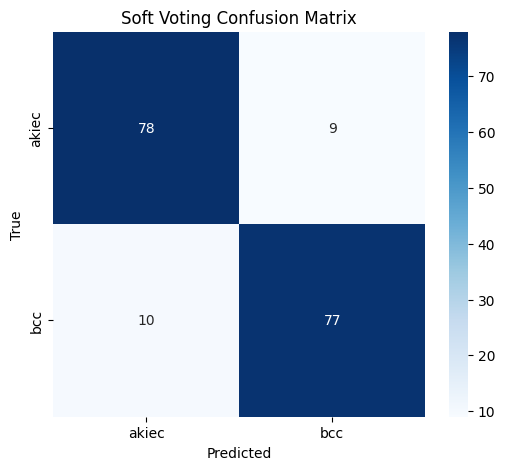

In [ ]:
print("== Soft Voting Evaluation ==")
print(classification_report(y_true, soft_final,
      target_names=class_labels, digits=4))

cm = confusion_matrix(y_true, soft_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Soft Voting Confusion Matrix")
plt.show()

## Weighted Soft Voting


In [ ]:
from sklearn.metrics import f1_score

best_score = 0
best_weights = (0, 0, 0)

for w1 in np.arange(0, 1.1, 0.1):
    for w2 in np.arange(0, 1.1 - w1, 0.1):
        w3 = 1.0 - w1 - w2
        if w3 < 0:
            continue

        weighted_preds = (
            w1 * densenet_preds +
            w2 * xception_preds +
            w3 * cnn_preds
        )

        pred_labels = np.argmax(weighted_preds, axis=1)
        score = f1_score(y_true, pred_labels, average='macro')

        if score > best_score:
            best_score = score
            best_weights = (w1, w2, w3)

print("Best F1 Score (macro):", best_score)
print("Best Weights: DenseNet=%.2f, Xception=%.2f, CNN=%.2f" % best_weights)

Best F1 Score (macro): 0.9079973562458692
Best Weights: DenseNet=0.40, Xception=0.20, CNN=0.40


In [ ]:
weighted_preds = (
    0.4 * densenet_preds +
    0.2 * xception_preds +
    0.4 * cnn_preds
)
weighted_final = np.argmax(weighted_preds, axis=1)

== Weighted Soft Voting ==
              precision    recall  f1-score   support

       akiec     0.9277    0.8851    0.9059        87
         bcc     0.8901    0.9310    0.9101        87

    accuracy                         0.9080       174
   macro avg     0.9089    0.9080    0.9080       174
weighted avg     0.9089    0.9080    0.9080       174



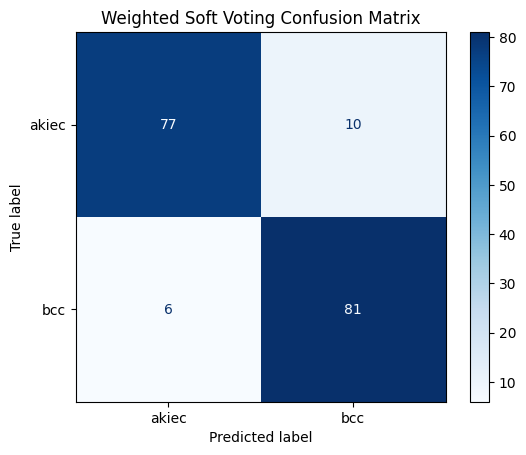

In [ ]:
print("== Weighted Soft Voting ==")
print(classification_report(y_true, weighted_final,
      target_names=class_labels, digits=4))

ConfusionMatrixDisplay(confusion_matrix(
    y_true, weighted_final), display_labels=class_labels).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()

# 4 - Final Ensemble Decision


For the malignant subtype classification task—distinguishing between AKIEC and BCC—we evaluated multiple ensemble strategies combining predictions from three independently fine-tuned models: Xception, DenseNet121, and a custom CNN. All models were trained using consistent preprocessing and augmentation pipelines to ensure compatibility within the ensemble.

After performing a grid search to optimize model weights based on macro F1-score, the best-performing configuration was determined as:

- DenseNet121: 40%

- Xception: 20%

- CNN: 40%

This ensemble achieved:

- Macro F1-score: 0.9080

- Accuracy: 90.8%

- Recall for BCC: 93.1%

- Precision for AKIEC: 92.8%

The confusion matrix confirms the model’s robustness, with minimal misclassifications between AKIEC and BCC cases. Based on these results, this weighted soft voting ensemble was selected as the final prediction strategy for malignant subtype classification in our system.


In [ ]:
weighted_preds = (
    0.4 * densenet_preds +
    0.2 * xception_preds +
    0.4 * cnn_preds
)
weighted_final = np.argmax(weighted_preds, axis=1)

== Weighted Soft Voting ==
              precision    recall  f1-score   support

       akiec     0.9277    0.8851    0.9059        87
         bcc     0.8901    0.9310    0.9101        87

    accuracy                         0.9080       174
   macro avg     0.9089    0.9080    0.9080       174
weighted avg     0.9089    0.9080    0.9080       174



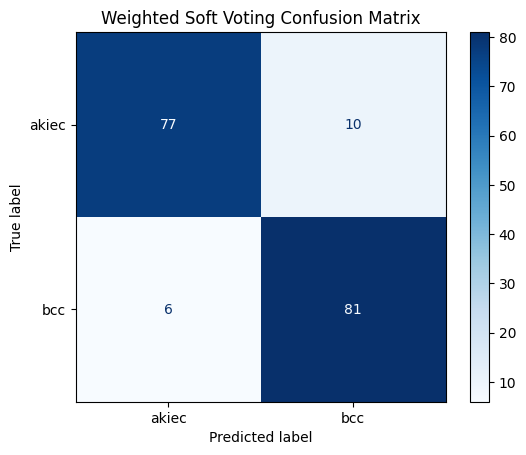

In [ ]:
print("== Weighted Soft Voting ==")
print(classification_report(y_true, weighted_final,
      target_names=class_labels, digits=4))

ConfusionMatrixDisplay(confusion_matrix(
    y_true, weighted_final), display_labels=class_labels).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()